# Plot Scratchpad Results

## Prerequisites

In [2]:
import copy
import datetime
import importlib
import re

import itertools
from collections import defaultdict

from pathlib import Path

import numpy as np
from tqdm import tqdm

import plotnine as p9

import pandas as pd
from collections import deque

from utils import add_src_to_sys_path

add_src_to_sys_path()

from common import wandb_utils, nest
from common import plotnine_utils as p9u

wandb_utils = importlib.reload(wandb_utils)
p9u = importlib.reload(p9u)

## Load the experiments

In [3]:
tags = ["scratchpad_f", "classic", "sanity_check"]

In [5]:
plot_dir_name = "__".join(tags) + "_2"
output_dir = Path("output_plots") / f"{plot_dir_name}_aggr"
output_dir.mkdir(parents=True, exist_ok=True)

In [6]:
df = wandb_utils.download_and_load_results(
    tags=tags,
    force_download=False,
)
len(df)

1983

In [7]:
df_scratchpad = wandb_utils.download_and_load_results(
    tags=["scratchpad_f"],
    force_download=False,
)
len(df_scratchpad)

1635

In [8]:
df_classic = wandb_utils.download_and_load_results(
    tags=["classic"],
    force_download=False,
)
len(df_classic)

136

In [9]:
df_sanity_check = wandb_utils.download_and_load_results(
    tags=["sanity_check"],
    force_download=False,
)
len(df_sanity_check)

401

In [10]:
df = pd.concat([df_sanity_check, df_classic, df_scratchpad], ignore_index=True)

In [11]:
df = df[
    (df["cfg__dataset.name"] != "sum")
    & (df["cfg__model.position_encoding_type"] != "new_rotary")
]

In [12]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")

overall_acc_pattern = re.compile(r"pred\/(\w+)_acc_(.+)")
scratchpad_acc_pattern = re.compile(r"pred\/(\w+)__(\w+)_([\w\[\],\s]+)")


CATEGORY_TO_DATASET = {
    "classic": ["scan", "pcfg", "clutrr"],
    "sanity_check": ["s2s_copy", "s2s_reverse", "s2s_halfcopy"],
    "scratchpad": ["s2s_addition", "s2s_sort", "s2s_lego", "s2s_sum", "s2s_parity", "s2s_poly"],
}

DATASET_TO_CATEGORY = {
    ds: cat
    for cat, ds_list in CATEGORY_TO_DATASET.items()
    for ds in ds_list
}


def get_split(key: str) -> str:
    if "test" in key:
        return "test"
    elif "valid" in key:
        return "validation"
    else:
        raise ValueError()


def get_category(ds, ds_split, key: str) -> int:
    if key == "overall":
        return -1
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    if "[" in key and "]" in key and "," in key:
        return int(key.split("[")[1].split("]")[0].split(",")[0])
    else:
        return int(key)


xdf_data = deque()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if row["job_type"] != "best_run_seed_exp":
        continue

    group = row["run_group"]

    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)

    dataset_name = row["cfg__dataset.name"]
    dataset_split = row["cfg__dataset.split"]
    dataset_pretty = wandb_utils.get_pretty_dataset_name(dataset_name, dataset_split)

    pe_name = wandb_utils.get_pretty_pe_name(row["cfg__model.position_encoding_type"])

    seed = int(row["cfg__global_vars.seed"])

    train_runtime = row.get("sum__train/train_runtime", None)

    # Overall Accuracy
    for k, v in row.items():
        if np.all(pd.isnull(v)):
            continue

        if k.startswith("sum__pred/"):
            prediction_split = get_split(k)
            try:
                if "_acc_" in k:
                    o = overall_acc_pattern.search(k)
                    category = o.group(2)
                    length = get_category(dataset_name, dataset_split, category)
                    metric = "output_acc"
                else:
                    k2 = k.replace("__overall", "_overall")
                    o = scratchpad_acc_pattern.search(k2)
                    # print(k2)
                    if o is None:
                        continue

                    category = o.group(3)
                    length = get_category(dataset_name, dataset_split, category)
                    metric = o.group(2)
            except Exception as e:
                print("category", k)
                print(group)
                print(category)
                print(k)
                # raise e
                raise e

            xdf_data.append({
                "scratchpad_config": scratchpad_config,
                "ds": dataset_name,
                "ds_split": dataset_split,
                "ds_category": DATASET_TO_CATEGORY[dataset_name],
                "dataset_name": dataset_pretty,
                "pe": pe_name,
                "prediction_split": prediction_split,
                metric: float(v),
                "seq_length": length,
                "category": category,
                "seed": seed
            })

oxdf = pd.DataFrame.from_records(xdf_data)
oxdf

100%|██████████| 1998/1998 [00:20<00:00, 95.34it/s] 


,scratchpad_config,ds,ds_split,ds_category,dataset_name,pe,prediction_split,output_acc,seq_length,category,seed,correct_steps,correct_inputs,failed_steps,correct_remaining_inputs,correct_computations,correct_intermediate_variables,correct_outputs
0,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,sanity_check,Copy (2x),No PE,test,0.9220,26,26,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,sanity_check,Copy (2x),No PE,test,0.6460,29,29,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,sanity_check,Copy (2x),No PE,test,0.0000,39,39,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,sanity_check,Copy (2x),No PE,validation,0.9872,16,16,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,sanity_check,Copy (2x),No PE,test,0.1420,32,32,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287137,no_scratchpad,s2s_addition,len_tr8_ts16,scratchpad,Addition,Absolute Sinusoid,validation,NaN,4,4,256788,NaN,NaN,0.0,NaN,NaN,NaN,NaN
287138,no_scratchpad,s2s_addition,len_tr8_ts16,scratchpad,Addition,Absolute Sinusoid,test,0.0000,14,14-by-1,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287139,no_scratchpad,s2s_addition,len_tr8_ts16,scratchpad,Addition,Absolute Sinusoid,test,0.0000,15,15-by-13,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287140,no_scratchpad,s2s_addition,len_tr8_ts16,scratchpad,Addition,Absolute Sinusoid,test,0.0000,9,9-by-6,256788,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
del xdf_data

In [14]:
len(oxdf)

287142

## Plot MRR

In [15]:
import itertools
from collections import defaultdict

def compute_mean_reciprocal_rank(
        scores_df: pd.DataFrame, config_names
) -> pd.DataFrame:
    scores_df = scores_df.copy()
    # Filter out submissions that don't have all the splits
    # scores_df = scores_df[scores_df[config_names].notnull().all(axis=1)]
    for config_name in config_names:
        rank = scores_df[config_name].rank(method="first", ascending=False)
        scores_df[f"rr_{config_name}"] = 1 / rank

    # Compute mean reciprocal rank per each row
    scores_df["mrr"] = scores_df[
        [f"rr_{config_name}" for config_name in config_names]
    ].mean(axis=1)

    return scores_df

def get_mrr_df(orig_xdf, ds_and_splits, metric_name):
    ds_configs = [(ds, split) for ds, split in ds_and_splits]
    ds_configs = [{"ds": ds, "ds_split": split} for ds, split in ds_configs]
    seeds = sorted(orig_xdf["seed"].unique().tolist())
    mrr_queries = [{"seed": s, **dc} for dc, s in itertools.product(ds_configs, seeds)]


    xdf = orig_xdf[(orig_xdf["seq_length"] == -1) & (orig_xdf["prediction_split"] == "test") & (orig_xdf[metric_name].isnull() == False)]

    mrr_df_data = defaultdict(dict)
    for query in mrr_queries:
        scratchpad_configs = xdf[
            (xdf["ds"] == query["ds"]) &
            (xdf["ds_split"] == query["ds_split"])
            ]["scratchpad_config"].unique().tolist()
        scratchpad_configs.sort()
        new_queries = [{"scratchpad_config": sc, **query} for sc in scratchpad_configs]

        for q in new_queries:
            q_name = "__".join([str(q[k]) for k in sorted(q.keys())])
            pdf = xdf
            for k, v in q.items():
                pdf = pdf[(pdf[k] == v)]
            for _, row in pdf.iterrows():
                mrr_df_data[row["pe"]][q_name] = row[metric_name]

    mrr_df_data = [{"pe": key, **values} for key, values in mrr_df_data.items()]
    mrr_df = pd.DataFrame.from_records(mrr_df_data)

    # Remove columns that have all NaNs
    mrr_df = mrr_df.dropna(axis=1)
    config_names = [col for col in mrr_df.columns if col != "pe"]
    mrr_xdf = compute_mean_reciprocal_rank(mrr_df, config_names)
    return mrr_xdf

In [16]:
oxdf["ds"].unique()

array(['s2s_copy', 's2s_reverse', 'pcfg', 'scan', 's2s_sum', 's2s_poly',
       's2s_lego', 's2s_parity', 's2s_sort', 's2s_addition'], dtype=object)

In [17]:
oxdf["ds_split"].unique()

array(['cmc2x_tr20_ts40', 'rsc2x_tr20_ts40', 'rdc_tr20_ts40',
       'cmc_tr20_ts40', 'mc2x_tr20_ts40', 'mcrv_tr20_ts40',
       'mc_tr20_ts40', 'rsc_tr20_ts40', 'md_productivity',
       'mdlen_tr25_ts48', 'productivity', 'len_tr25_ts48', 'len_tr8_ts16',
       'n_terms_tr8_ts16', 'len_mltd_tr8_ts16', 'len_sngd_tr8_ts16'],
      dtype=object)

## Plot MRR for all datasets

In [18]:
unique_ds_and_splits = sorted(oxdf[["ds", "ds_split"]].drop_duplicates().values.tolist())
unique_ds_and_splits

[['pcfg', 'md_productivity'],
 ['pcfg', 'productivity'],
 ['s2s_addition', 'len_tr8_ts16'],
 ['s2s_copy', 'cmc2x_tr20_ts40'],
 ['s2s_copy', 'cmc_tr20_ts40'],
 ['s2s_copy', 'rdc_tr20_ts40'],
 ['s2s_copy', 'rsc2x_tr20_ts40'],
 ['s2s_copy', 'rsc_tr20_ts40'],
 ['s2s_lego', 'len_tr8_ts16'],
 ['s2s_parity', 'len_tr8_ts16'],
 ['s2s_poly', 'n_terms_tr8_ts16'],
 ['s2s_reverse', 'mc2x_tr20_ts40'],
 ['s2s_reverse', 'mc_tr20_ts40'],
 ['s2s_reverse', 'mcrv_tr20_ts40'],
 ['s2s_sort', 'len_mltd_tr8_ts16'],
 ['s2s_sort', 'len_sngd_tr8_ts16'],
 ['s2s_sum', 'len_tr8_ts16'],
 ['scan', 'len_tr25_ts48'],
 ['scan', 'mdlen_tr25_ts48']]

In [19]:
unique_ds_and_splits

[['pcfg', 'md_productivity'],
 ['pcfg', 'productivity'],
 ['s2s_addition', 'len_tr8_ts16'],
 ['s2s_copy', 'cmc2x_tr20_ts40'],
 ['s2s_copy', 'cmc_tr20_ts40'],
 ['s2s_copy', 'rdc_tr20_ts40'],
 ['s2s_copy', 'rsc2x_tr20_ts40'],
 ['s2s_copy', 'rsc_tr20_ts40'],
 ['s2s_lego', 'len_tr8_ts16'],
 ['s2s_parity', 'len_tr8_ts16'],
 ['s2s_poly', 'n_terms_tr8_ts16'],
 ['s2s_reverse', 'mc2x_tr20_ts40'],
 ['s2s_reverse', 'mc_tr20_ts40'],
 ['s2s_reverse', 'mcrv_tr20_ts40'],
 ['s2s_sort', 'len_mltd_tr8_ts16'],
 ['s2s_sort', 'len_sngd_tr8_ts16'],
 ['s2s_sum', 'len_tr8_ts16'],
 ['scan', 'len_tr25_ts48'],
 ['scan', 'mdlen_tr25_ts48']]

In [20]:
oxdf2 = oxdf.copy()
oxdf2 = oxdf2[oxdf2["scratchpad_config"] == "no_scratchpad"]

In [27]:
ds_configs_to_exclude = [
    ['pcfg', 'productivity'],
    ['scan', 'len_tr25_ts48'],
]
unique_ds_and_splits = [(ds, split) for ds, split in unique_ds_and_splits if [ds, split] not in ds_configs_to_exclude]
mrr_xdf = get_mrr_df(oxdf, unique_ds_and_splits, "output_acc")
mrr_xdf

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_12738/2059987198.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

,pe,pcfg__md_productivity__no_scratchpad__146317,pcfg__md_productivity__no_scratchpad__234054,pcfg__md_productivity__no_scratchpad__256788,s2s_addition__len_tr8_ts16__i0_c1_o1_v0_r0__146317,s2s_addition__len_tr8_ts16__i0_c1_o1_v1_r1__146317,s2s_addition__len_tr8_ts16__i1_c0_o1_v1_r1__146317,s2s_addition__len_tr8_ts16__i1_c1_o0_v1_r1__146317,s2s_addition__len_tr8_ts16__i1_c1_o1_v0_r1__146317,s2s_addition__len_tr8_ts16__i1_c1_o1_v1_r0__146317,...,rr_s2s_sum__len_tr8_ts16__i1_c0_o1_v1_r1__256788,rr_s2s_sum__len_tr8_ts16__i1_c1_o0_v1_r1__256788,rr_s2s_sum__len_tr8_ts16__i1_c1_o1_v0_r1__256788,rr_s2s_sum__len_tr8_ts16__i1_c1_o1_v1_r0__256788,rr_s2s_sum__len_tr8_ts16__i1_c1_o1_v1_r1__256788,rr_s2s_sum__len_tr8_ts16__no_scratchpad__256788,rr_scan__mdlen_tr25_ts48__no_scratchpad__146317,rr_scan__mdlen_tr25_ts48__no_scratchpad__234054,rr_scan__mdlen_tr25_ts48__no_scratchpad__256788,mrr
0,Rotary,0.4208,0.4605,0.4348,0.0579,0.0592,0.0642,0.0645,0.0854,0.0412,...,0.250000,0.200000,0.200000,0.200000,0.250000,0.200000,0.250000,0.250000,0.250000,0.269750
1,ALiBi,0.4265,0.4189,0.4390,0.1061,0.1028,0.0952,0.1254,0.1058,0.1257,...,0.333333,0.333333,0.333333,0.500000,0.333333,0.500000,0.333333,0.333333,0.333333,0.551252
2,T5's Relative Bias,0.4109,0.4461,0.4593,0.1786,0.1582,0.1656,0.1570,0.1939,0.1432,...,0.500000,0.500000,0.500000,0.333333,0.500000,0.333333,1.000000,1.000000,0.500000,0.603950
3,Absolute Sinusoid,0.3692,0.3785,0.3517,0.0447,0.0714,0.0688,0.0739,0.0763,0.0308,...,0.200000,0.250000,0.250000,0.250000,0.200000,0.250000,0.200000,0.200000,0.200000,0.228131
4,No PE,0.4174,0.4437,0.4386,0.1781,0.1294,0.1623,0.1553,0.1479,0.1679,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,1.000000,0.630250


In [21]:
oxdf2 = oxdf.copy()
oxdf2 = oxdf2[oxdf2["scratchpad_config"] == "no_scratchpad"]
ds_configs_to_exclude = [
    ['pcfg', 'productivity'],
    ['scan', 'len_tr25_ts48'],
]
unique_ds_and_splits = [(ds, split) for ds, split in unique_ds_and_splits if [ds, split] not in ds_configs_to_exclude]
mrr_xdf = get_mrr_df(oxdf2, unique_ds_and_splits, "output_acc")
mrr_xdf

,pe,pcfg__md_productivity__no_scratchpad__146317,pcfg__md_productivity__no_scratchpad__234054,pcfg__md_productivity__no_scratchpad__256788,s2s_addition__len_tr8_ts16__no_scratchpad__146317,s2s_addition__len_tr8_ts16__no_scratchpad__234054,s2s_addition__len_tr8_ts16__no_scratchpad__256788,s2s_copy__cmc2x_tr20_ts40__no_scratchpad__146317,s2s_copy__cmc2x_tr20_ts40__no_scratchpad__234054,s2s_copy__cmc2x_tr20_ts40__no_scratchpad__256788,...,rr_s2s_sort__len_sngd_tr8_ts16__no_scratchpad__146317,rr_s2s_sort__len_sngd_tr8_ts16__no_scratchpad__234054,rr_s2s_sort__len_sngd_tr8_ts16__no_scratchpad__256788,rr_s2s_sum__len_tr8_ts16__no_scratchpad__146317,rr_s2s_sum__len_tr8_ts16__no_scratchpad__234054,rr_s2s_sum__len_tr8_ts16__no_scratchpad__256788,rr_scan__mdlen_tr25_ts48__no_scratchpad__146317,rr_scan__mdlen_tr25_ts48__no_scratchpad__234054,rr_scan__mdlen_tr25_ts48__no_scratchpad__256788,mrr
0,Rotary,0.4208,0.4605,0.4348,0.0009,0.0002,0.0002,0.0427,0.0382,0.0472,...,0.250000,0.250000,0.250000,0.200000,0.250000,0.200000,0.250000,0.250000,0.250000,0.329739
1,ALiBi,0.4265,0.4189,0.4390,0.0786,0.0738,0.0800,0.5453,0.5857,0.5767,...,0.333333,0.333333,0.333333,1.000000,0.333333,0.500000,0.333333,0.333333,0.333333,0.502288
2,T5's Relative Bias,0.4109,0.4461,0.4593,0.0744,0.0579,0.0839,0.5085,0.5128,0.5505,...,0.500000,0.500000,0.500000,0.333333,0.500000,0.333333,1.000000,1.000000,0.500000,0.549020
3,Absolute Sinusoid,0.3692,0.3785,0.3517,0.0062,0.0022,0.0049,0.0399,0.0368,0.0418,...,0.200000,0.200000,0.200000,0.250000,0.200000,0.250000,0.200000,0.200000,0.200000,0.215359
4,No PE,0.4174,0.4437,0.4386,0.0694,0.0726,0.1115,0.4279,0.4239,0.4403,...,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.500000,0.500000,1.000000,0.686928


In [22]:
len(unique_ds_and_splits)

17

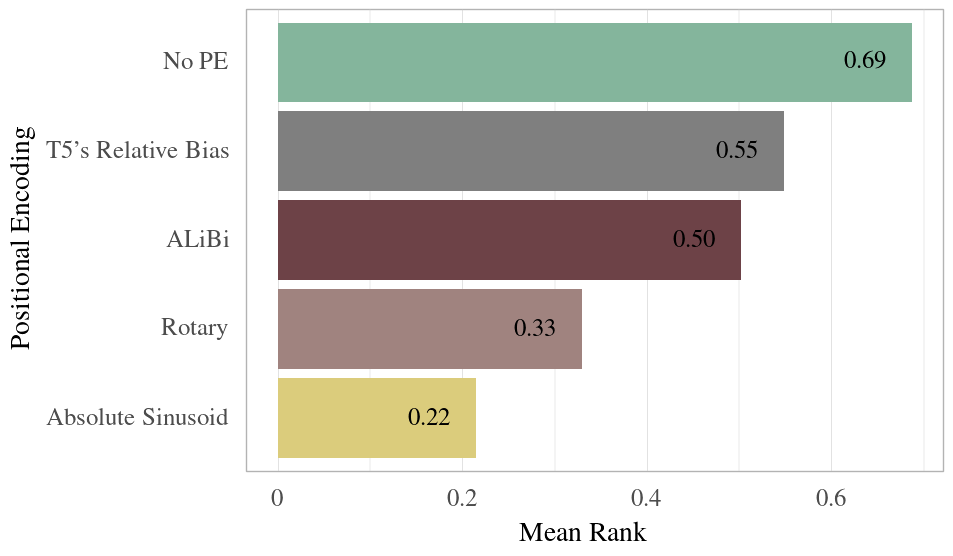

<ggplot: (8774421002484)>

In [23]:
import plotnine as p9

pdf = mrr_xdf

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=-0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=18,
    )
    + p9.coord_flip()
    + p9.labs(
        x="Positional Encoding",
        y="Mean Rank",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9u.scale_fill_prism("FB_bellsprout")
    + p9u.scale_color_prism("FB_bellsprout_dark")
    #         + p9.theme_light()
    + p9u.theme_ipsum(
        grid="Xx",
        axis="xy",
        base_family="Times New Roman",
        base_size=20,
        axis_title_size=20,
        axis_text_size=18,
    )
    #         + p9.theme_light()
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
        #             # legend_box_spacing=0.20,
                    legend_position="none",
        #             # legend_box="vertical",
        figure_size=(9, 6)
    )
)
# p.save(output_dir / "mrr.pdf", dpi=300)
p

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_2_aggr/mrr_poster.pdf


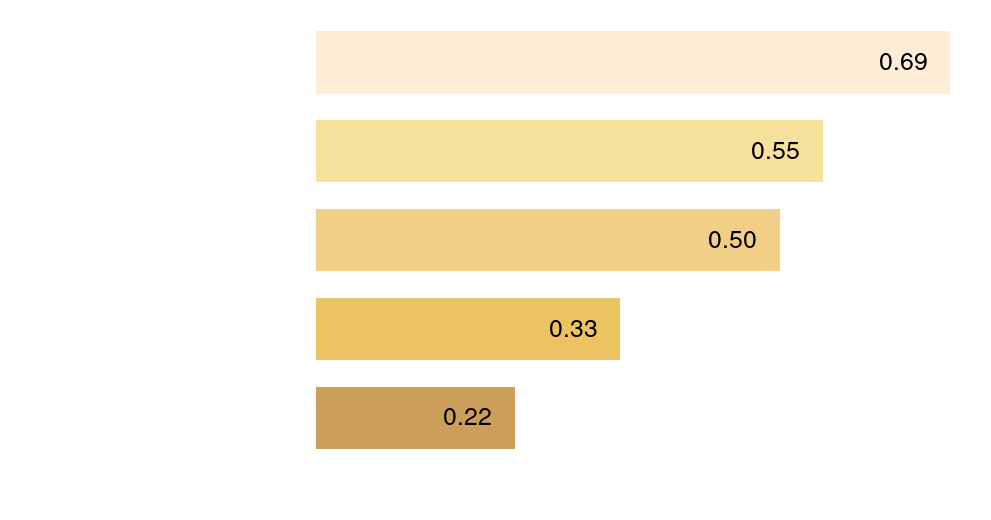

<ggplot: (8766049614812)>

In [33]:
import plotnine as p9

pdf = mrr_xdf

# Fix pe names
def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No Position Encoding"
    elif pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No Position Encoding", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        width = 0.7
#         fill="#ecc363",
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=-0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=18,
    )
    + p9.coord_flip()
    + p9.labs(
        x="",
        y="",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9u.scale_fill_prism("FB_yellows")
    + p9u.scale_color_prism("FB_yellows")
    #         + p9.theme_light()
    + p9u.theme_ipsum(
        grid="Xx",
        axis="xy",
        base_family="helvetica",
        base_size=20,
        axis_title_size=20,
        axis_text_size=18,
    )
    #         + p9.theme_light()
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
        #             # legend_box_spacing=0.20,
                    legend_position="none",
        #             # legend_box="vertical",
        panel_background=p9.element_blank(),
        panel_border=p9.element_blank(),
        axis_text_x=p9.element_text(margin=dict(t=15), color="white", size=0),
        axis_text_y=p9.element_text(margin=dict(r=15), color="white"),
        panel_grid_major_x=p9.element_blank(),
        panel_grid_major_y=p9.element_blank(),
        panel_grid_minor_x=p9.element_blank(),
        panel_grid_minor_y=p9.element_blank(),
        figure_size=(9, 6)
    )
)
p.save(output_dir / "mrr_poster.pdf", dpi=300)
p

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 11 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_2_aggr/mrr_presentation.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


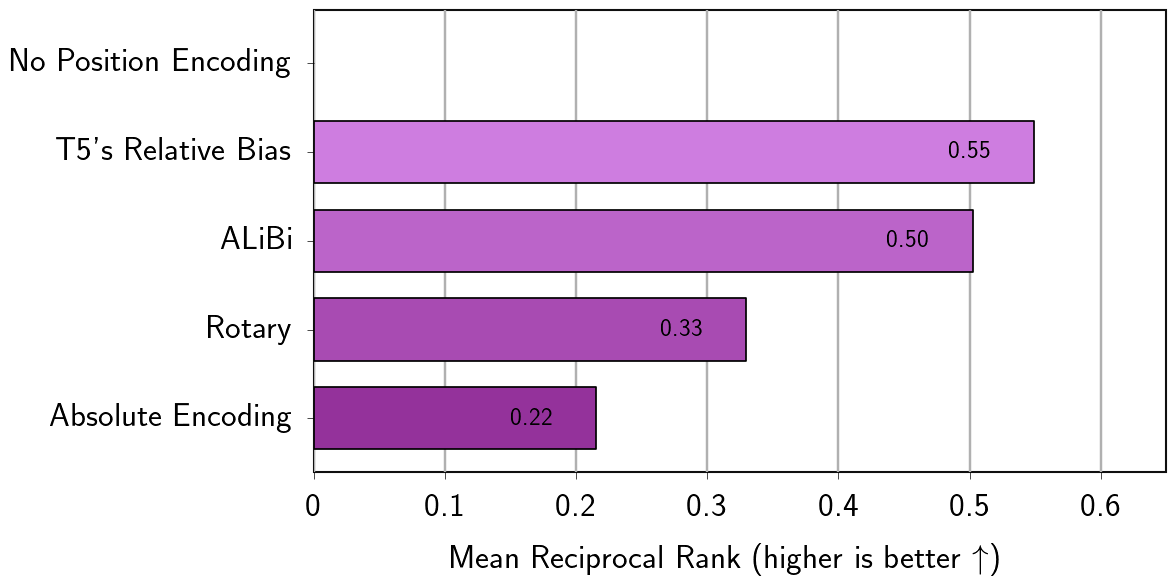

<ggplot: (8766047560250)>

In [38]:
import plotnine as p9

pdf = mrr_xdf.copy()

# Fix pe names
def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No Position Encoding"
    elif pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No Position Encoding", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        width = 0.7,
        color="black",
        size=0.7,
#         fill="#ecc363",
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=-0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=18,
    )
    + p9.coord_flip()
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank (higher is better $\uparrow$)",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.1), limits=[0, 0.65], expand=(0,0))
    + p9u.scale_fill_prism("mila_purples_reverse")
#     + p9u.scale_fill_prism("mila_purpl")
#     + p9u.scale_color_prism("FB_yellows")
    #         + p9.theme_light()
    + p9u.theme_formal(
        grid="X",
        base_family="Computer Modern Sans serif",
        base_size=24,
#         axis_title_size=20,
        axis_text_size=24,
    )
    + p9.theme(
        legend_position="none",
        figure_size=(11, 6)
    )
)
p.save(output_dir / "mrr_presentation.pdf", dpi=300)
p

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 13 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_2_aggr/paper_teaser.pdf


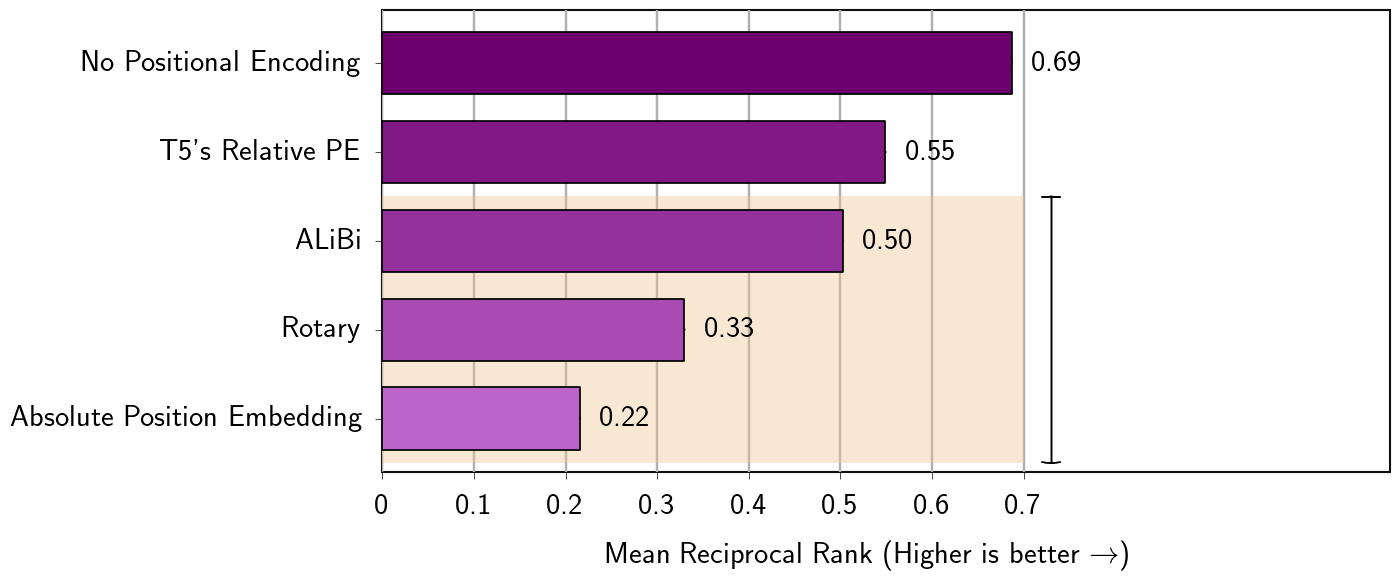

<ggplot: (8774417848826)>

In [25]:
import plotnine as p9

pdf = mrr_xdf.copy()

# Fix pe names
def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No Positional Encoding"
    elif pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No Positional Encoding", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_point(size=0)
    + p9.annotate("rect", xmin=0.5, xmax=3.5, ymin=0, ymax=0.7, alpha=0.4, fill="#EBC591")
#     + p9.annotate("segment", x=0.5, xmax=3.5, y=0, ymax=0.85)
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        width = 0.7,
        color="black",
        size=0.7,
#         fill="#ecc363",
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=+0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=22,
    )
#     + p9.geom_text(
#         label=r"\noindent Positional Encoding \\ used in \\ BLOOM, \\ PaLM,\\ LLaMA",
#         x=2,
#         y=0.75,
#         ha="left",
#         size=20
#     )
    + p9.geom_segment(
        x=0.5, xend=3.5, y=0.73, yend=0.73, 
        arrow=p9.arrow(length=0.04,type="closed", ends="both")
    )
    + p9.coord_flip()
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank (Higher is better $\rightarrow$)",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.scale_y_continuous(breaks=np.arange(0, 0.71, 0.1), limits=[0, 1.1], expand=(0,0))
    + p9u.scale_fill_prism("mila_purples")
#     + p9u.scale_fill_prism("mila_purpl")
#     + p9u.scale_color_prism("FB_yellows")
    #         + p9.theme_light()
    + p9u.theme_formal(
        grid="X",
        base_family="Computer Modern Sans serif",
        base_size=22,
#         axis_title_size=20,
        axis_text_size=22,
    )
    + p9.theme(
        legend_position="none",
        figure_size=(13, 6)
    )
)
p.save(output_dir / "paper_teaser.pdf", dpi=300)
p

In [ ]:
import plotnine as p9

pdf = mrr_xdf

# Fix pe names
def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No Position Encoding"
    elif pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No Position Encoding", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        width = 0.7,
        color="black",
        size=0.7,
#         fill="#ecc363",
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=-0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=18,
    )
    + p9.coord_flip()
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank (higher is better $\uparrow$)",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.1), limits=[0, 0.65], expand=(0,0))
    + p9u.scale_fill_prism("mila_purples_reverse")
#     + p9u.scale_fill_prism("mila_purpl")
#     + p9u.scale_color_prism("FB_yellows")
    #         + p9.theme_light()
    + p9u.theme_formal(
        grid="X",
        base_family="Computer Modern Sans serif",
        base_size=24,
#         axis_title_size=20,
        axis_text_size=24,
    )
    + p9.theme(
        legend_position="none",
        figure_size=(11, 6)
    )
)
p.save(output_dir / "mrr_presentation.pdf", dpi=300)
p

In [17]:
! pip install matplotlib

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_aggr/mrr.pdf


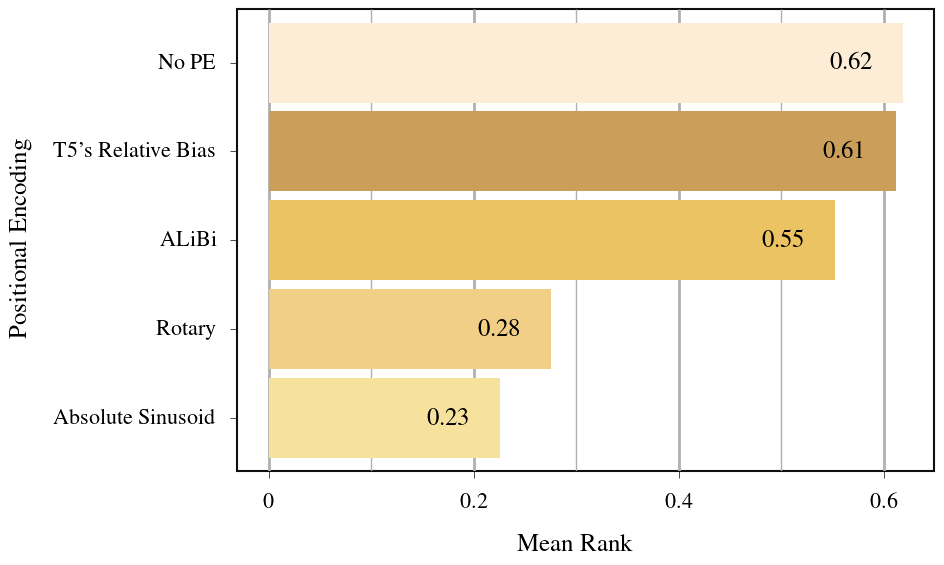

<ggplot: (8783130748663)>

In [43]:
import plotnine as p9
from matplotlib import rc
rc('text', usetex=True)

pdf = mrr_xdf

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="reorder(pe, mrr)", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
#         width=0.7,
    )
    + p9.geom_text(
        mapping=p9.aes(label="mrr"),
        nudge_y=-0.05,
        # va='bottom',
        format_string="{:.2f}",
        size=18,
    )
    + p9.coord_flip()
    + p9.labs(
        x="Positional Encoding",
        y="Mean Rank",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9u.scale_fill_prism("FB_yellows")
    + p9u.scale_color_prism("formal")
#     + p9u.scale_color_and_fill_formal()
    #         + p9.theme_light()
    + p9u.theme_formal(
#         base_family="Times New Roman",
#         base_size=20,
#         axis_title_size=20,
        axis_text_size=16,
        grid="Xx"
    )
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
        #             # legend_box_spacing=0.20,
                    legend_position="none",
        #             # legend_box="vertical",
        figure_size=(9, 6)
    )
)
p.save(output_dir / "mrr.pdf", dpi=300)
p

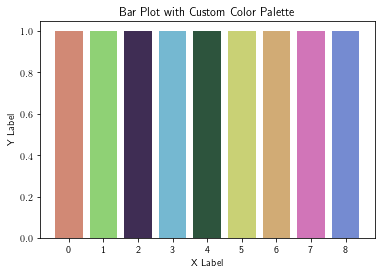

In [40]:
import matplotlib.pyplot as plt

# Define the color palette
color_palette = [
    "#d18975",
    "#8fd175",
    "#3f2d54",
    "#75b8d1",
    "#2d543d",
    "#c9d175",
    "#d1ab75",
    "#d175b8",
    "#758bd1"
  ]

# Define the data for the bar plot
x_values = [str(i) for i in range(len(color_palette))]
y_values = [1 for i in range(len(color_palette))]

# Create the bar plot with the given color palette
fig, ax = plt.subplots()
ax.bar(x_values, y_values, color=color_palette)

# Set the title and axis labels
ax.set_title("Bar Plot with Custom Color Palette")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")

# Show the plot
plt.show()

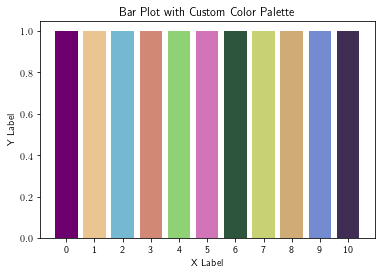

In [91]:
import matplotlib.pyplot as plt

# Define the color palette
color_palette = [
    "#6e006e",
    "#EBC591",
    "#75b8d1",
    "#d18975",
    "#8fd175",
    "#d175b8",
    "#2d543d",
    "#c9d175",
    "#d1ab75",
    "#758bd1",
    "#3f2d54",
  ]

# Define the data for the bar plot
x_values = [str(i) for i in range(len(color_palette))]
y_values = [1 for i in range(len(color_palette))]

# Create the bar plot with the given color palette
fig, ax = plt.subplots()
ax.bar(x_values, y_values, color=color_palette)

# Set the title and axis labels
ax.set_title("Bar Plot with Custom Color Palette")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")

# Show the plot
plt.show()

## Plot MRR Per Dataset Category

In [40]:
ds_configs_to_exclude = [
    ['pcfg', 'productivity'],
    ['scan', 'len_tr25_ts48'],
]

DS_CATEGORY_PRETTY_NAME = {
    "sanity_check": "Primitive Tasks",
    "scratchpad": r"Mathematical \& Reasoning",
    "classic": "Classic Len. Gen. Datasets",
}

mrr_xdf_lst = []
for cat in CATEGORY_TO_DATASET.keys():
    xdf = oxdf[oxdf["ds_category"] == cat].copy()
    xdf = xdf[xdf["scratchpad_config"] == "no_scratchpad"]
    
    unique_ds_and_splits = sorted(xdf[["ds", "ds_split"]].drop_duplicates().values.tolist())
    unique_ds_and_splits = [(ds, split) for ds, split in unique_ds_and_splits if [ds, split] not in ds_configs_to_exclude]
    mrr_xdf = get_mrr_df(xdf, unique_ds_and_splits, "output_acc")
    mrr_xdf["ds_category"] = DS_CATEGORY_PRETTY_NAME[cat]
    mrr_xdf_lst.append(mrr_xdf)

mrr_xdf = pd.concat(mrr_xdf_lst)

In [220]:
pdf = mrr_xdf

# # Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
# pdf["pe"] = pdf["pe"].apply(fix_nope_name)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["No", "T5", "AL", "Ro", "Ab"]
)


p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="new_pe", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        color="black",
        size=0.7,
        width=0.7,
    )
#     + p9.coord_flip()
    + p9.facet_wrap("ds_category", ncol=3)
    + p9.labs(
        x="Positional Encoding",
        y="Mean Rank",
        color="",
        fill="",
        shape="",
    )
    + p9u.scale_fill_prism("formal")
    + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    #         + p9.theme_light()
    + p9u.theme_formal(grid="Yy", base_size=28, axis_text_size=24, strip_text_size=28)
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
                    legend_box_spacing=0.7,
                    legend_entry_spacing=40,
                    legend_position="bottom",
        legend_text=p9.element_text(size=28),
#                     legend_box="vertical",
        panel_spacing=0.3,
        figure_size=(20, 5)
    )
)
# p.save(output_dir / "mrr_per_ds_category.pdf", dpi=300)
p

ValueError: items in new_categories are not the same as in old categories

['Rotary' 'ALiBi' "T5's Relative Bias" 'Absolute Encoding' 'No PE']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 3 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_2_aggr/mrr_per_ds_category_paper.pdf


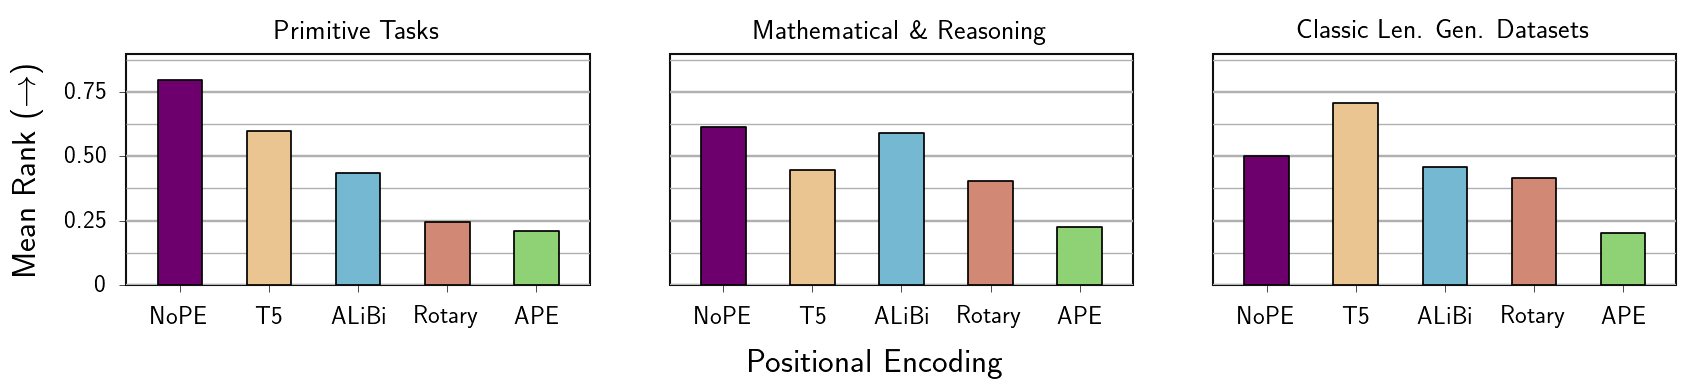

<ggplot: (8766046855590)>

In [43]:
pdf = mrr_xdf.copy()

# # Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf["pe"].apply(fix_nope_name)
# pdf["pe"] = pdf["pe"].apply(fix_nope_name)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
print(pdf["pe"].unique())
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

def get_short_pe_names(pe):
    if pe == "No PE":
        return "NoPE"
    if pe == "T5's Relative Bias":
        return "T5"
    if pe == "ALiBi":
        return "ALiBi"
    if pe == "Absolute Encoding":
        return "APE"
    return pe

pdf["new_pe"] = pdf["pe"].apply(get_short_pe_names)
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["NoPE", "T5", "ALiBi", "Rotary", "APE"]
)

pdf["ds_category"] = pdf["ds_category"].astype("category")
pdf["ds_category"] = pdf["ds_category"].cat.reorder_categories(
    ["Primitive Tasks", r"Mathematical \& Reasoning", "Classic Len. Gen. Datasets"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="new_pe", y="mrr"))
    + p9.geom_col(
        mapping=p9.aes(fill="pe"),
        color="black",
        size=0.7,
        width=0.5,
    )
#     + p9.coord_flip()
    + p9.facet_wrap("ds_category", ncol=3)
    + p9.labs(
        x="Positional Encoding",
        y=r"Mean Rank ($\rightarrow$)",
        color="",
        fill="",
        shape="",
    )
    + p9u.scale_fill_prism("formal")
    + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="Yy", base_size=24, axis_text_size=18, strip_text_size=20
    )
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
                    legend_box_spacing=0.7,
#                     legend_entry_spacing=40,
                    legend_position="none",
        legend_text=p9.element_text(size=28),
#                     legend_box="vertical",
        panel_spacing=0.8,
        figure_size=(20, 3)
    )
)
p.save(output_dir / "mrr_per_ds_category_paper.pdf", dpi=300)
p

## Plot Scratchpad Format Rank

In [289]:
ds_configs_to_exclude = [
    ['pcfg', 'productivity'],
    ['scan', 'len_tr25_ts48'],
    # ['s2s_lego', 'len_tr8_ts16'],
    # ['s2s_parity', 'len_tr8_ts16'],
    # ['s2s_poly', 'n_terms_tr8_ts16']
]

unique_ds_and_splits = sorted(oxdf[oxdf["ds_category"] == "scratchpad"][["ds", "ds_split"]].drop_duplicates().values.tolist())
unique_ds_and_splits = [(ds, split) for ds, split in unique_ds_and_splits if [ds, split] not in ds_configs_to_exclude]
unique_ds_and_splits

[('s2s_addition', 'len_tr8_ts16'),
 ('s2s_lego', 'len_tr8_ts16'),
 ('s2s_parity', 'len_tr8_ts16'),
 ('s2s_poly', 'n_terms_tr8_ts16'),
 ('s2s_sort', 'len_mltd_tr8_ts16'),
 ('s2s_sort', 'len_sngd_tr8_ts16'),
 ('s2s_sum', 'len_tr8_ts16')]

In [290]:
seeds = sorted(oxdf["seed"].unique().tolist())
ds_configs = [{"ds": ds, "ds_split": split} for ds, split in unique_ds_and_splits]
mrr_queries = [{"seed": s, **dc} for dc, s in itertools.product(ds_configs, seeds)]
mrr_queries

[{'seed': 146317, 'ds': 's2s_addition', 'ds_split': 'len_tr8_ts16'},
 {'seed': 234054, 'ds': 's2s_addition', 'ds_split': 'len_tr8_ts16'},
 {'seed': 256788, 'ds': 's2s_addition', 'ds_split': 'len_tr8_ts16'},
 {'seed': 146317, 'ds': 's2s_lego', 'ds_split': 'len_tr8_ts16'},
 {'seed': 234054, 'ds': 's2s_lego', 'ds_split': 'len_tr8_ts16'},
 {'seed': 256788, 'ds': 's2s_lego', 'ds_split': 'len_tr8_ts16'},
 {'seed': 146317, 'ds': 's2s_parity', 'ds_split': 'len_tr8_ts16'},
 {'seed': 234054, 'ds': 's2s_parity', 'ds_split': 'len_tr8_ts16'},
 {'seed': 256788, 'ds': 's2s_parity', 'ds_split': 'len_tr8_ts16'},
 {'seed': 146317, 'ds': 's2s_poly', 'ds_split': 'n_terms_tr8_ts16'},
 {'seed': 234054, 'ds': 's2s_poly', 'ds_split': 'n_terms_tr8_ts16'},
 {'seed': 256788, 'ds': 's2s_poly', 'ds_split': 'n_terms_tr8_ts16'},
 {'seed': 146317, 'ds': 's2s_sort', 'ds_split': 'len_mltd_tr8_ts16'},
 {'seed': 234054, 'ds': 's2s_sort', 'ds_split': 'len_mltd_tr8_ts16'},
 {'seed': 256788, 'ds': 's2s_sort', 'ds_split': 'l

In [292]:
# Dataframe structure:
#  pe   | query_1_acc | query_2_acc | ...
#  None | 0.3         | 0.3         | ...
#  t5 | 0.3         | 0.3         | ...
wandb_utils = importlib.reload(wandb_utils)

metric_name = "output_acc"
xdf = oxdf[(oxdf["seq_length"] == -1) & (oxdf["prediction_split"] == "test") & (oxdf[metric_name].isnull() == False)]
xdf["scratchpad_config"] = xdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name,
    axis=1
)

# xdf = xdf[xdf["scratchpad_config"] != "No Scratchpad"]
xdf = xdf

from collections import defaultdict
def get_mrr_df(xxdf):
    mrr_df_data = defaultdict(dict)
    for query in mrr_queries:
        q = query
        q_name = "__".join([str(q[k]) for k in sorted(q.keys())])
        pdf = xxdf[wandb_utils.create_mask(xxdf, q)]
        for _, row in pdf.iterrows():
            mrr_df_data[row["scratchpad_config"]][q_name] = row[metric_name]

    mrr_df_data = [{"scratchpad_config": key, **values} for key, values in mrr_df_data.items()]
    mrr_df = pd.DataFrame.from_records(mrr_df_data)
    original_columns = set(mrr_df.columns)
    num_nans = mrr_df.isna().sum().sum()
    mrr_df = mrr_df.dropna(axis=1)
    dropped_columns = original_columns - set(mrr_df.columns)
    if num_nans > 0:
        print(f"WARNING: {num_nans} NaNs in mrr_df", xxdf["pe"].unique().tolist())
        print("Dropped columns:", dropped_columns)

    config_names = [col for col in mrr_df.columns if col != "scratchpad_config"]
#     print(config_names)
    mrr_xdf = compute_mean_reciprocal_rank(mrr_df, config_names)
    return mrr_xdf

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_88855/4051085788.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dropped columns: {'s2s_lego__len_tr8_ts16__234054', 's2s_sort__len_sngd_tr8_ts16__234054', 's2s_sort__len_mltd_tr8_ts16__256788', 's2s_sort__len_mltd_tr8_ts16__234054', 's2s_lego__len_tr8_ts16__146317', 's2s_sort__len_mltd_tr8_ts16__146317', 's2s_sort__len_sngd_tr8_ts16__256788', 's2s_lego__len_tr8_ts16__256788', 's2s_sort__len_sngd_tr8_ts16__146317'}
['s2s_addition__len_tr8_ts16__146317', 's2s_addition__len_tr8_ts16__234054', 's2s_addition__len_tr8_ts16__256788', 's2s_parity__len_tr8_ts16__146317', 's2s_parity__len_tr8_ts16__234054', 's2s_parity__len_tr8_ts16__256788', 's2s_poly__n_terms_tr8_ts16__146317', 's2s_poly__n_terms_tr8_ts16__234054', 's2s_poly__n_terms_tr8_ts16__256788']
Dropped columns: {'s2s_lego__len_tr8_ts16__234054', 's2s_sort__len_sngd_tr8_ts16__234054', 's2s_sort__len_mltd_tr8_ts16__256788', 's2s_sort__len_mltd_tr8_ts16__234054', 's2s_lego__len_tr8_ts16__146317', 's2s_sort__len_mltd_tr8_ts16__146317', 's2s_sort__len_sngd_tr8_ts16__256788', 's2s_lego__len_tr8_ts16__256

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



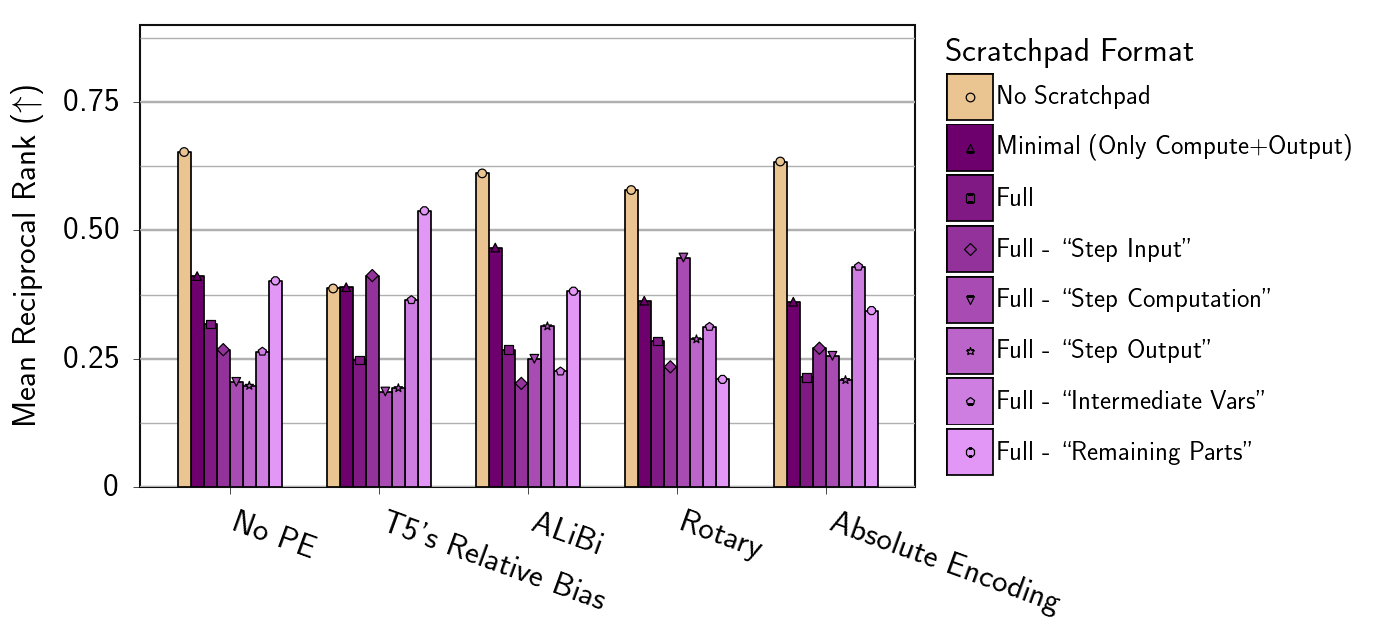

<ggplot: (8779996506950)>

In [265]:
wandb_utils = importlib.reload(wandb_utils)

# xdf = xdf[xdf["pe"] != "Rotary (Fixed)"]
pe_lst = sorted(xdf["pe"].unique().tolist())
df_lst = []
for pe in pe_lst:
    pdf = get_mrr_df(xdf[xdf["pe"] == pe])
    pdf["pe"] = pe
    df_lst.append(pdf)

pdf = pd.concat(df_lst, ignore_index=True)

pdf = pdf[pdf["pe"] != "Rotary (Fixed)"]

def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)


existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order2() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")
    
pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="pe", y="mrr", fill="scratchpad_config"))
    + p9.geom_col(
        position="dodge",
        width=0.7,
        size=0.7,
        color="black",
    )
    + p9.geom_point(
        mapping=p9.aes(shape="scratchpad_config"),
        position=p9.position_dodge(0.7),
#         width=0.7,
        size=3,
        color="black",
#         fill="black"
    )
    + p9.scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1), limits=[0,1],
    )
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank ($\uparrow$)",
        fill="Scratchpad Format",
        color="Scratchpad Format",
        shape="Scratchpad Format",
    )
    # )
    + p9u.scale_fill_prism("mila_p_and_y")
    + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="Yy", 
        base_size=24,
        axis_text_size=24
    )

    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(10, 6),
        axis_text_x=p9.element_text(rotation=-20, hjust=0),
    )
)
p
# p.save(output_dir / "scratchpad_mrr.pdf", dpi=300)
p

In [237]:
sag_mrr[["scratchpad_config", "s2s_sum__len_tr8_ts16__234054", "s2s_sum__len_tr8_ts16__256788", "rr_s2s_sum__len_tr8_ts16__234054", "rr_s2s_sum__len_tr8_ts16__256788", "mrr"]]

,scratchpad_config,s2s_sum__len_tr8_ts16__234054,s2s_sum__len_tr8_ts16__256788,rr_s2s_sum__len_tr8_ts16__234054,rr_s2s_sum__len_tr8_ts16__256788,mrr
0,"Removing ""Step Output""",0.3722,0.2175,1.000000,0.200000,0.295455
1,"Removing ""Intermediate Vars""",0.3116,0.2590,0.333333,0.500000,0.341775
2,Minimal (Only Compute+Output),0.2827,0.1261,0.200000,0.125000,0.300108
3,"Removing ""Step Computation""",0.2621,0.2019,0.142857,0.166667,0.210281
4,Full,0.3139,0.2980,0.500000,1.000000,0.347727
5,"Removing ""Step Input""",0.2941,0.2452,0.250000,0.333333,0.363745
6,"Removing ""Remaining Parts""",0.1528,0.1755,0.125000,0.142857,0.392857
7,No Scratchpad,0.2741,0.2231,0.166667,0.250000,0.465909


In [235]:
sag_mrr.columns

Index(['scratchpad_config', 's2s_addition__len_tr8_ts16__146317',
       's2s_addition__len_tr8_ts16__234054',
       's2s_addition__len_tr8_ts16__256788',
       's2s_parity__len_tr8_ts16__146317', 's2s_parity__len_tr8_ts16__234054',
       's2s_parity__len_tr8_ts16__256788',
       's2s_poly__n_terms_tr8_ts16__146317',
       's2s_poly__n_terms_tr8_ts16__234054',
       's2s_poly__n_terms_tr8_ts16__256788', 's2s_sum__len_tr8_ts16__234054',
       's2s_sum__len_tr8_ts16__256788',
       'rr_s2s_addition__len_tr8_ts16__146317',
       'rr_s2s_addition__len_tr8_ts16__234054',
       'rr_s2s_addition__len_tr8_ts16__256788',
       'rr_s2s_parity__len_tr8_ts16__146317',
       'rr_s2s_parity__len_tr8_ts16__234054',
       'rr_s2s_parity__len_tr8_ts16__256788',
       'rr_s2s_poly__n_terms_tr8_ts16__146317',
       'rr_s2s_poly__n_terms_tr8_ts16__234054',
       'rr_s2s_poly__n_terms_tr8_ts16__256788',
       'rr_s2s_sum__len_tr8_ts16__234054', 'rr_s2s_sum__len_tr8_ts16__256788',
       'm

Dropped columns: {'s2s_lego__len_tr8_ts16__234054', 's2s_sort__len_sngd_tr8_ts16__234054', 's2s_sort__len_mltd_tr8_ts16__256788', 's2s_sort__len_mltd_tr8_ts16__234054', 's2s_lego__len_tr8_ts16__146317', 's2s_sort__len_mltd_tr8_ts16__146317', 's2s_sort__len_sngd_tr8_ts16__256788', 's2s_lego__len_tr8_ts16__256788', 's2s_sort__len_sngd_tr8_ts16__146317', 's2s_sum__len_tr8_ts16__146317'}
Dropped columns: {'s2s_lego__len_tr8_ts16__234054', 's2s_sort__len_sngd_tr8_ts16__234054', 's2s_sort__len_mltd_tr8_ts16__256788', 's2s_sort__len_mltd_tr8_ts16__234054', 's2s_lego__len_tr8_ts16__146317', 's2s_sort__len_mltd_tr8_ts16__146317', 's2s_sort__len_sngd_tr8_ts16__256788', 's2s_lego__len_tr8_ts16__256788', 's2s_sort__len_sngd_tr8_ts16__146317', 's2s_sum__len_tr8_ts16__146317'}
Dropped columns: {'s2s_lego__len_tr8_ts16__234054', 's2s_sort__len_sngd_tr8_ts16__234054', 's2s_sort__len_mltd_tr8_ts16__256788', 's2s_sort__len_mltd_tr8_ts16__234054', 's2s_lego__len_tr8_ts16__146317', 's2s_sort__len_mltd_tr8

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_aggr/scratchpad_mrr_per_model.pdf


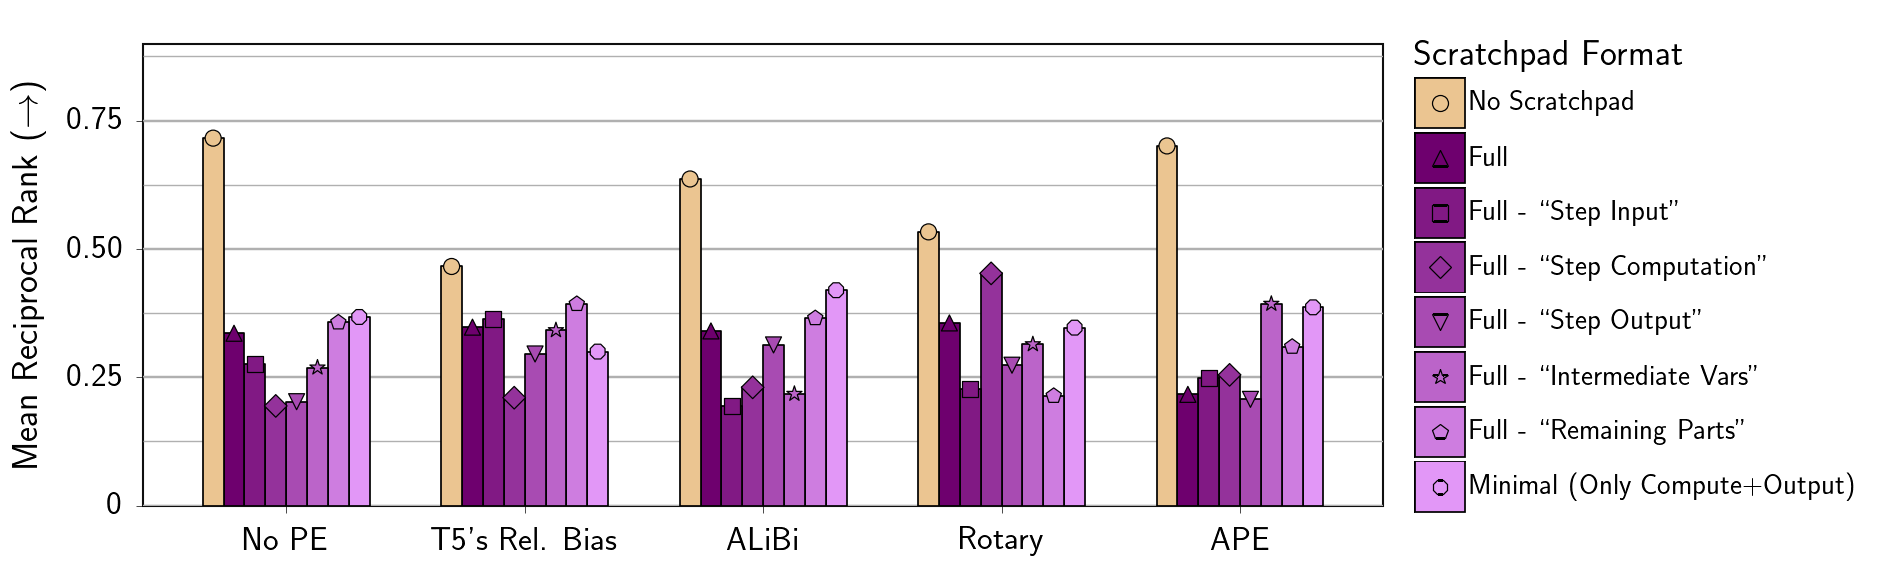

<ggplot: (8779981076914)>

In [293]:
wandb_utils = importlib.reload(wandb_utils)

# xdf = xdf[xdf["pe"] != "Rotary (Fixed)"]
pe_lst = sorted(xdf["pe"].unique().tolist())
df_lst = []
for pe in pe_lst:
    pdf = get_mrr_df(xdf[xdf["pe"] == pe]).copy()
    pdf["pe"] = pe
    df_lst.append(pdf)

pdf = pd.concat(df_lst, ignore_index=True)
pdf = pdf.copy()

pdf = pdf[pdf["pe"] != "Rotary (Fixed)"]

def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No PE"
    if pe_name.lower() == "absolute sinusoid":
        return "APE"
    if "t5" in pe_name.lower():
        return "T5's Rel. Bias"
    return pe_name

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Rel. Bias", "ALiBi", "Rotary", "APE"]
)


existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order3() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
#     sc_name = sc_name.replace("Step Input", r"Step Input ($\mathcal{I}$)")
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")
    
pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="pe", y="mrr", fill="scratchpad_config"))
    + p9.geom_col(
        position="dodge",
        width=0.7,
        size=0.7,
        color="black",
    )
    + p9.geom_point(
        mapping=p9.aes(shape="scratchpad_config"),
        position=p9.position_dodge(0.7),
#         width=0.7,
        size=6,
        color="black",
#         fill="black"
    )
    + p9.scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1), limits=[0,1],
    )
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank ($\rightarrow$)",
        fill="Scratchpad Format",
        color="Scratchpad Format",
        shape="Scratchpad Format",
    )
    # )
    + p9u.scale_fill_prism("mila_p_and_y")
    + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="Yy", 
        base_size=26,
        axis_text_size=24
    )

    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(16, 6),
#         axis_text_x=p9.element_text(rotation=-20, hjust=0),
    )
)
p
p.save(output_dir / "scratchpad_mrr_per_model.pdf", dpi=300)
p

## Plot Per Dataset Best Performing Scratchpad Config

In [294]:
ds_configs_to_exclude = [
    ['pcfg', 'productivity'],
    ['scan', 'len_tr25_ts48'],
    # ['s2s_lego', 'len_tr8_ts16'],
    # ['s2s_parity', 'len_tr8_ts16'],
    # ['s2s_poly', 'n_terms_tr8_ts16']
]

unique_ds_and_splits = sorted(oxdf[oxdf["ds_category"] == "scratchpad"][["ds", "ds_split"]].drop_duplicates().values.tolist())
unique_ds_and_splits = [(ds, split) for ds, split in unique_ds_and_splits if [ds, split] not in ds_configs_to_exclude]
unique_ds_and_splits

[('s2s_addition', 'len_tr8_ts16'),
 ('s2s_lego', 'len_tr8_ts16'),
 ('s2s_parity', 'len_tr8_ts16'),
 ('s2s_poly', 'n_terms_tr8_ts16'),
 ('s2s_sort', 'len_mltd_tr8_ts16'),
 ('s2s_sort', 'len_sngd_tr8_ts16'),
 ('s2s_sum', 'len_tr8_ts16')]

In [295]:
seeds = sorted(oxdf["seed"].unique().tolist())
pe_list = sorted(oxdf["pe"].unique().tolist())
mrr_queries = [{"seed": s, "pe": pe} for pe, s in itertools.product(pe_list, seeds)]
mrr_queries

[{'seed': 146317, 'pe': 'ALiBi'},
 {'seed': 234054, 'pe': 'ALiBi'},
 {'seed': 256788, 'pe': 'ALiBi'},
 {'seed': 146317, 'pe': 'Absolute Sinusoid'},
 {'seed': 234054, 'pe': 'Absolute Sinusoid'},
 {'seed': 256788, 'pe': 'Absolute Sinusoid'},
 {'seed': 146317, 'pe': 'No PE'},
 {'seed': 234054, 'pe': 'No PE'},
 {'seed': 256788, 'pe': 'No PE'},
 {'seed': 146317, 'pe': 'Rotary'},
 {'seed': 234054, 'pe': 'Rotary'},
 {'seed': 256788, 'pe': 'Rotary'},
 {'seed': 146317, 'pe': "T5's Relative Bias"},
 {'seed': 234054, 'pe': "T5's Relative Bias"},
 {'seed': 256788, 'pe': "T5's Relative Bias"}]

In [296]:
# Dataframe structure:
#  pe   | query_1_acc | query_2_acc | ...
#  None | 0.3         | 0.3         | ...
#  t5 | 0.3         | 0.3         | ...
wandb_utils = importlib.reload(wandb_utils)

metric_name = "output_acc"
xdf = oxdf[(oxdf["seq_length"] == -1) & (oxdf["prediction_split"] == "test") & (oxdf[metric_name].isnull() == False)]
xdf["scratchpad_config"] = xdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name,
    axis=1
)

from collections import defaultdict
def get_mrr_df(xxdf):
    mrr_df_data = defaultdict(dict)
    for query in mrr_queries:
        q = query
        q_name = "__".join([str(q[k]) for k in sorted(q.keys())])
        pdf = xxdf[wandb_utils.create_mask(xxdf, q)]
        if len(pdf) > 8:
            raise ValueError("Too many configs for query: {}".format(q))
        for _, row in pdf.iterrows():
            mrr_df_data[row["scratchpad_config"]][q_name] = row[metric_name]

    mrr_df_data = [{"scratchpad_config": key, **values} for key, values in mrr_df_data.items()]
    mrr_df = pd.DataFrame.from_records(mrr_df_data)
    original_columns = set(mrr_df.columns)
    num_nans = mrr_df.isna().sum().sum()
    mrr_df = mrr_df.dropna(axis=1)
    dropped_columns = original_columns - set(mrr_df.columns)
    if num_nans > 0:
        print(f"WARNING: {num_nans} NaNs in mrr_df", xxdf["ds"].unique().tolist(), xxdf["ds_split"].unique().tolist())
        print("Dropped columns:", dropped_columns)
    config_names = [col for col in mrr_df.columns if col != "scratchpad_config"]
    mrr_xdf = compute_mean_reciprocal_rank(mrr_df, config_names)
    return mrr_xdf

wandb_utils = importlib.reload(wandb_utils)

# xdf = xdf[xdf["pe"] != "Rotary (Fixed)"]
df_lst = []
for ds, ds_split in unique_ds_and_splits:
    pdf = get_mrr_df(xdf[(xdf["ds"] == ds) & (xdf["ds_split"] == ds_split)])
    pdf["ds_and_split"] = wandb_utils.get_pretty_dataset_name(ds, ds_split)
    df_lst.append(pdf)

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_88855/4091521327.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dropped columns: {"T5's Relative Bias__146317", "T5's Relative Bias__234054", 'No PE__146317', 'No PE__234054'}
Dropped columns: {'Absolute Sinusoid__146317', 'Rotary__234054', "T5's Relative Bias__146317", 'Rotary__146317', 'ALiBi__146317', 'No PE__146317'}


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



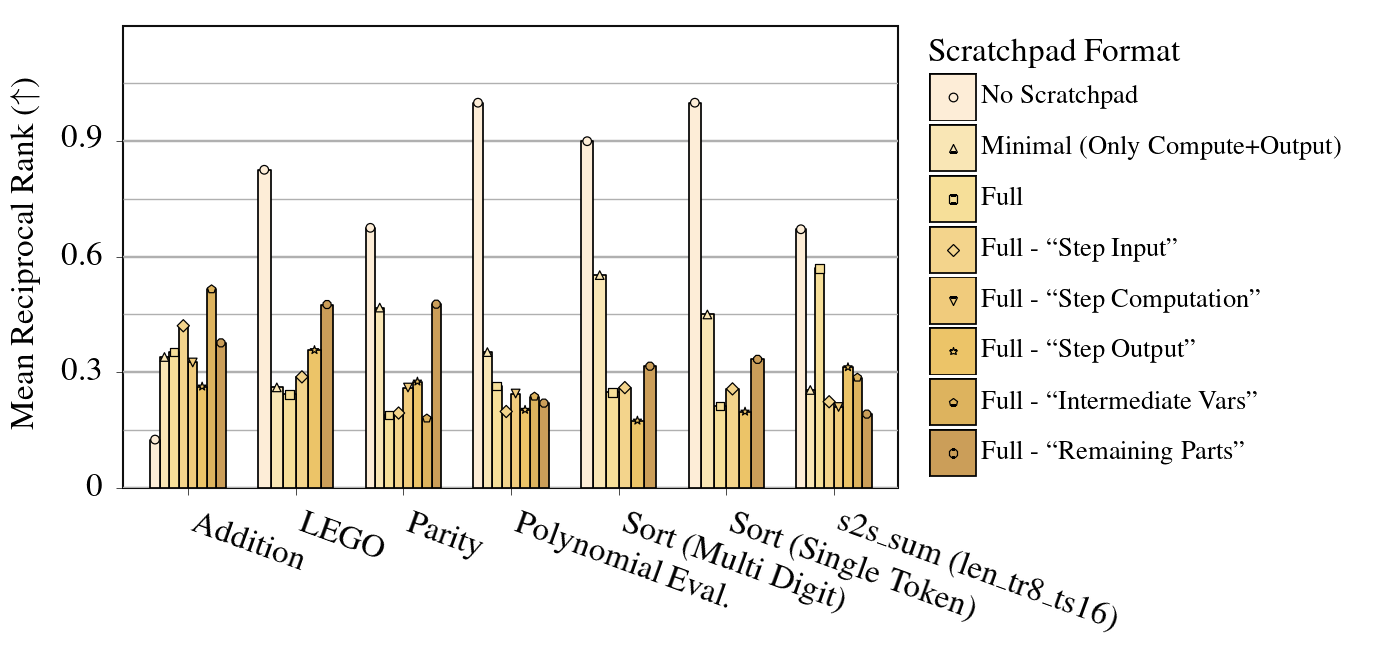

<ggplot: (8780004559216)>

In [297]:
wandb_utils = importlib.reload(wandb_utils)

pdf = pd.concat(df_lst, ignore_index=True)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order2() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")

pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="ds_and_split", y="mrr", fill="scratchpad_config"))
    + p9.geom_col(
        position="dodge",
        width=0.7,
        size=0.7,
        color="black",
    )
    + p9.geom_point(
        mapping=p9.aes(shape="scratchpad_config"),
        position=p9.position_dodge(0.7),
#         width=0.7,
        size=3,
        color="black",
#         fill="black"
    )
    + p9.scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1), limits=[0,1],
    )
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank ($\uparrow$)",
        fill="Scratchpad Format",
        color="Scratchpad Format",
        shape="Scratchpad Format",
    )
    # )
    + p9u.scale_fill_prism("FB_yellows8")
    + p9.scale_y_continuous(limits = (0, 1.2),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        grid="Yy",
        base_size=24,
        axis_text_size=24
    )

    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(10, 6),
        axis_text_x=p9.element_text(rotation=-20, hjust=0),
    )
)
p
# p.save(output_dir / "scratchpad_config_per_ds_mrr.pdf", dpi=300)
p

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



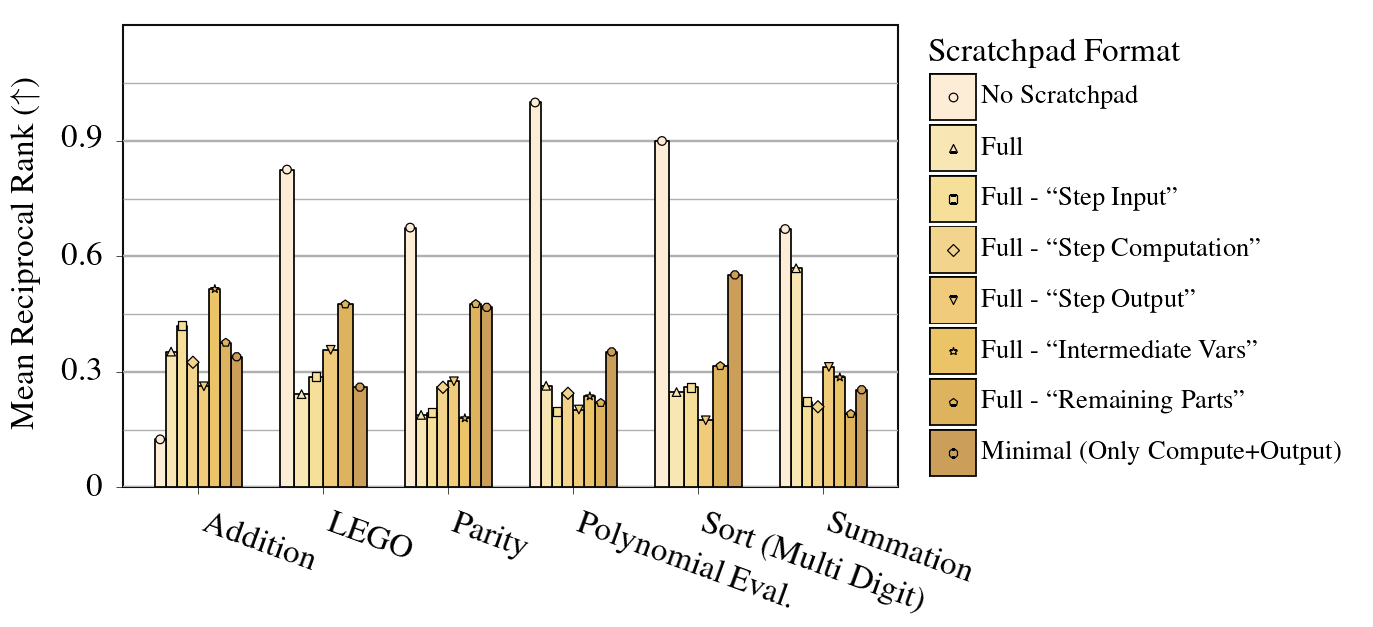

<ggplot: (8779996345107)>

In [300]:
wandb_utils = importlib.reload(wandb_utils)

pdf = pd.concat(df_lst, ignore_index=True).copy()

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order3() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")

pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)

pdf = pdf[pdf["ds_and_split"] != "Sort (Single Token)"]

def fix_ds_name(ds_name):
    if "s2s_sum" in ds_name:
        return "Summation"
    return ds_name

pdf["ds_and_split"] = pdf["ds_and_split"].apply(fix_ds_name)

p = (
    p9.ggplot(pdf, p9.aes(x="ds_and_split", y="mrr", fill="scratchpad_config"))
    + p9.geom_col(
        position="dodge",
        width=0.7,
        size=0.7,
        color="black",
    )
    + p9.geom_point(
        mapping=p9.aes(shape="scratchpad_config"),
        position=p9.position_dodge(0.7),
#         width=0.7,
        size=3,
        color="black",
#         fill="black"
    )
    + p9.scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1), limits=[0,1],
    )
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank ($\uparrow$)",
        fill="Scratchpad Format",
        color="Scratchpad Format",
        shape="Scratchpad Format",
    )
    # )
    + p9u.scale_fill_prism("FB_yellows8")
    + p9.scale_y_continuous(limits = (0, 1.2),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        grid="Yy",
        base_size=24,
        axis_text_size=24
    )

    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(10, 6),
        axis_text_x=p9.element_text(rotation=-20, hjust=0),
    )
)
p
# p.save(output_dir / "scratchpad_config_per_ds_mrr.pdf", dpi=300)
p

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_aggr/scratchpad_mrr_per_ds.pdf


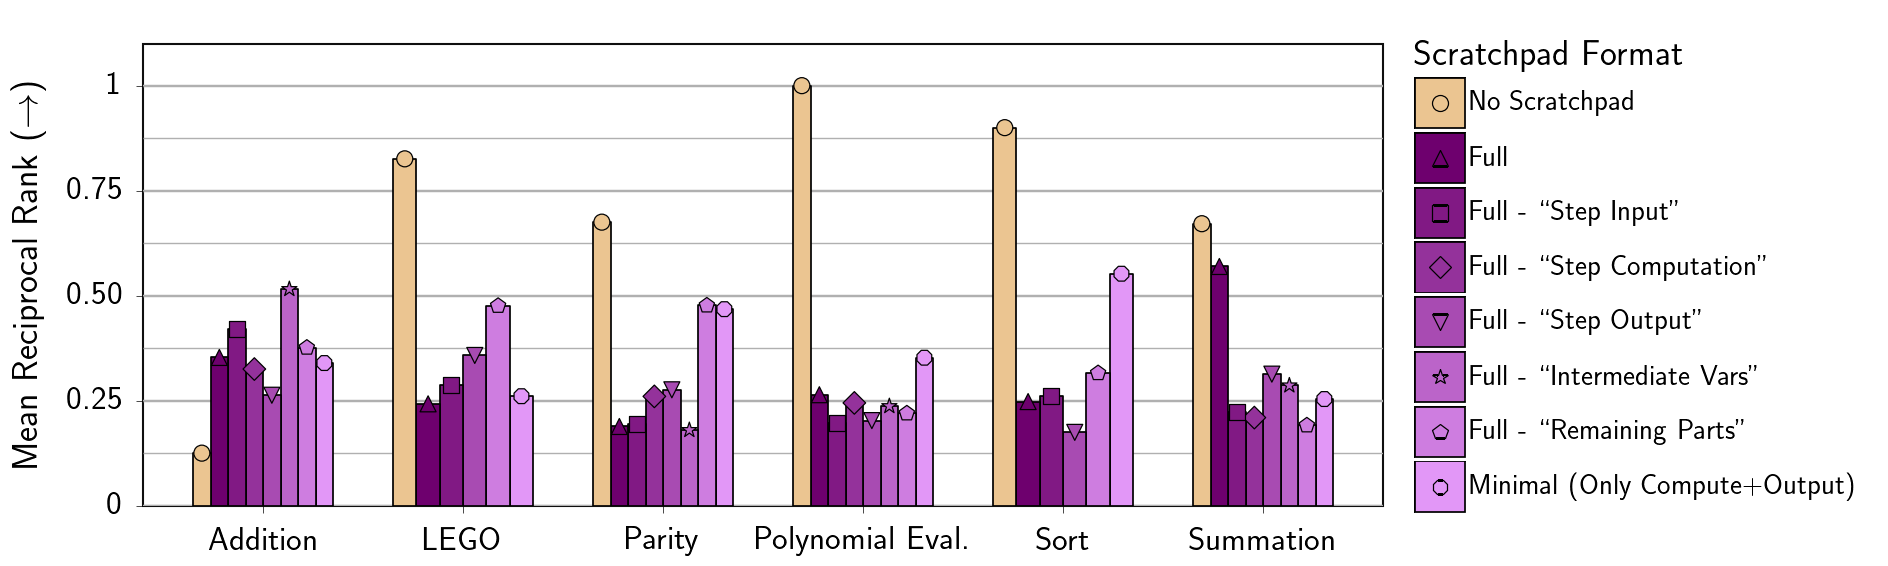

<ggplot: (8779977333393)>

In [308]:
wandb_utils = importlib.reload(wandb_utils)

pdf = pd.concat(df_lst, ignore_index=True).copy()

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order3() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")

pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)

pdf = pdf[pdf["ds_and_split"] != "Sort (Single Token)"]

def fix_ds_name(ds_name):
    if "s2s_sum" in ds_name:
        return "Summation"
    if "Sort" in ds_name:
        return "Sort"
    return ds_name

pdf["ds_and_split"] = pdf["ds_and_split"].apply(fix_ds_name)

p = (
    p9.ggplot(pdf, p9.aes(x="ds_and_split", y="mrr", fill="scratchpad_config"))
    + p9.geom_col(
        position="dodge",
        width=0.7,
        size=0.7,
        color="black",
    )
    + p9.geom_point(
        mapping=p9.aes(shape="scratchpad_config"),
        position=p9.position_dodge(0.7),
#         width=0.7,
        size=6,
        color="black",
#         fill="black"
    )
    + p9.scale_y_continuous(
    )
    + p9.labs(
        x=None,
        y=r"Mean Reciprocal Rank ($\rightarrow$)",
        fill="Scratchpad Format",
        color="Scratchpad Format",
        shape="Scratchpad Format",
    )
    # )
    + p9u.scale_fill_prism("mila_p_and_y")
    + p9.scale_y_continuous(limits = (0, 1.1),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="Yy", 
        base_size=26,
        axis_text_size=24
    )

    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(16, 6),
#         axis_text_x=p9.element_text(rotation=-20, hjust=0),
    )
)
p
p.save(output_dir / "scratchpad_mrr_per_ds.pdf", dpi=300)
p

## Plot Per Dataset Accuracy

In [325]:
xdf = oxdf[(oxdf["pe"] != "Rotary (Fixed)")]

# Find the best performing scratchpad config
aggr_cols = ["ds", "ds_split", "pe"]
unique_combs = xdf[aggr_cols].groupby(aggr_cols).count().reset_index()


def to_tuple(row):
    return tuple(row[c] for c in aggr_cols)


unique_combs = [to_tuple(comb) for _, comb in unique_combs.iterrows()]
aggr_to_best_performing_config = {
    comb: wandb_utils.get_best_performing_scratchpad_config(xdf, *comb)
    for comb in unique_combs
}

In [326]:
df_lst = [
    xdf[
        wandb_utils.create_mask(
            xdf,
            {
                **{c: v for c, v in zip(aggr_cols, comb)},
                **{"scratchpad_config": aggr_to_best_performing_config[comb]},
            },
        )
    ]
    for comb in unique_combs
]
# pdf = pd.concat(df_lst, ignore_index=True)
pdf = xdf

In [327]:
pdf = pdf[(pdf["seq_length"] == -1) & (pdf["output_acc"].notnull()) & (pdf["prediction_split"] == "test")]

In [328]:
wandb_utils = importlib.reload(wandb_utils)

wandb_utils.get_aggr_dataframe_with_mean_std(pdf, ["dataset_name", "pe"], "output_acc")

,dataset_name,pe,output_acc_mean,output_acc_std
0,Addition,ALiBi,0.104492,0.022008
1,Addition,Absolute Sinusoid,0.057183,0.028454
2,Addition,No PE,0.148475,0.033652
3,Addition,Rotary,0.048200,0.025833
4,Addition,T5's Relative Bias,0.151188,0.040649
...,...,...,...,...
85,scan (mdlen_tr25_ts48),ALiBi,0.438133,0.038469
86,scan (mdlen_tr25_ts48),Absolute Sinusoid,0.056867,0.013688
87,scan (mdlen_tr25_ts48),No PE,0.797267,0.029008
88,scan (mdlen_tr25_ts48),Rotary,0.282867,0.064184


['Lego', 'Copy', 'Pcfg', 'Reverse', 'Parity', 'Scan', 'Poly', 'Sort', 'Addition']
Categories (9, object): ['Reverse', 'Copy', 'Scan', 'Pcfg', ..., 'Parity', 'Lego', 'Poly', 'Sort']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 25 x 3 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/scratchpad_f__classic__sanity_check_aggr/per_task_avg_acc.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_summary : Removed 22 rows containing non-finite values.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_summary : Removed 22 rows containing non-finite values.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_errorbar 

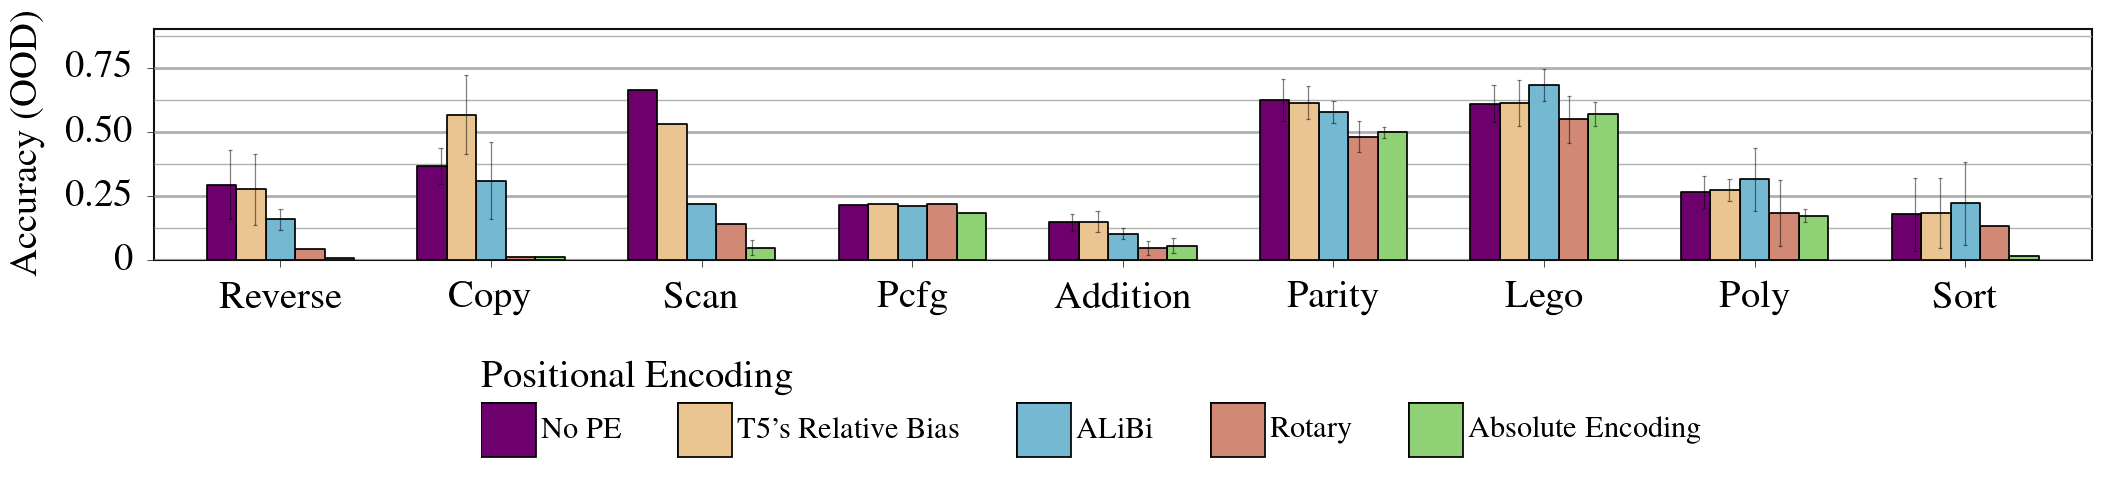

<ggplot: (8783131206012)>

In [335]:
p9u = importlib.reload(p9u)

pdf = pdf[
    (pdf["seq_length"] == -1)
    & (pdf["output_acc"].notnull())
    & (pdf["prediction_split"] == "test")
]

def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["No", "T5", "AL", "Ro", "Ab"]
)

def fix_ds_name(ds_name):
    return ds_name.replace("s2s_", "").capitalize()

pdf["ds"] = pdf["ds"].apply(fix_ds_name)
pdf["ds"] = pdf["ds"].astype("category")
print(pdf["ds"].unique())
pdf["ds"] = pdf["ds"].cat.reorder_categories(
    ["Reverse", "Copy", "Scan", "Pcfg", "Addition", "Parity", "Lego", "Poly", "Sort"]
)



p = (
    p9.ggplot(pdf, p9.aes(x="ds", y="output_acc", fill="pe"))
    + p9.geom_col(
        position="dodge",
        color="black",
        size=0.7,
        width=0.7,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_errorbar(
        p9.aes(group="pe"),
        position=p9.position_dodge(0.6),
        width=0.1,
        alpha=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1),
    )
    + p9.labs(
        x="Task",
        y="Accuracy (OOD)",
        fill="Positional Encoding",
        color="Positional Encoding",
    )
    # )
    + p9u.scale_fill_prism("formal")
    + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
#     + p9u.scale_color_prism("formal")
    #         + p9.theme_light()
    + p9u.theme_formal(grid="Yy", base_size=28, axis_text_size=28, strip_text_size=28)
    + p9.theme(
        # #             plot_margin=0,
#                     text=p9.element_text(size=20),
                    legend_box_spacing=0.7,
                    legend_entry_spacing=40,
                    legend_position="bottom",
        legend_text=p9.element_text(size=22),
#                     legend_box="vertical",
        panel_spacing=0.3,
        figure_size=(20, 5)
    )
    + p9.theme(
        #                     plot_margin=1,
#         text=p9.element_text(size=11),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
                figure_size=(25, 3),
        # axis_text_x=p9.element_text(rotation=-45, hjust=0),
    )
)
p.save(output_dir / "per_task_avg_acc.pdf", dpi=300)
p

## Plot Runtime

In [9]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")
def get_scratchpad_config(group: str):
    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)
    return scratchpad_config

xdf = df[(df["job_type"] != "agent")]
xdf["scratchpad_config"] = xdf["run_group"].apply(get_scratchpad_config)

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_11927/3517792464.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
xdf["runInfo__gpu"].unique()

array(['NVIDIA A100-SXM4-40GB', 'Quadro RTX 8000',
       'NVIDIA A100-SXM4-80GB', 'Tesla V100-SXM2-32GB',
       'NVIDIA A100 80GB PCIe'], dtype=object)

In [27]:
pdf = xdf

pdf["scratchpad_config"] = pdf.apply(
    lambda x: wandb_utils.get_pretty_scratchpad_config_name(
        x["scratchpad_config"], x["cfg__dataset.name"], x["cfg__dataset.split"],
    ),
    axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

pdf = pdf[
    (pdf["scratchpad_config"] == "Full") &
    (pdf["runInfo__gpu"] == "Tesla V100-SXM2-32GB") &
    (pdf["sum__train/train_runtime"].notnull()) &
    (pdf["cfg__model.position_encoding_type"] != "new_rotary")
]

pdf["pe"] = pdf.apply(
    lambda x: wandb_utils.get_pretty_pe_name(x["cfg__model.position_encoding_type"]),
    axis=1
)
existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

pdf["dataset_name"] = pdf.apply(
    lambda x: wandb_utils.get_pretty_dataset_name(x["cfg__dataset.name"], x["cfg__dataset.split"]),
    axis=1
)

pdf["runtime"] = pdf["sum__train/train_runtime"] / 60

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="dataset_name", fill="pe", y="runtime"))
    + p9.geom_col(
        position="dodge",
        width=0.6,
#         size=0.3,
#         color="black",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_errorbar(
        p9.aes(group="pe"),
        position=p9.position_dodge(0.6),
        width=0.1,
        alpha=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.labs(
        x="Positional Encoding",
        y="Train Runtime",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9u.scale_fill_prism("FB_bellsprout")
    + p9u.scale_color_prism("FB_bellsprout_dark")
    #         + p9.theme_light()
    + p9u.theme_ipsum(grid="Xx", axis="xy", base_family="Times New Roman")
    #         + p9.theme_light()
    #         + p9.theme(
    # #             plot_margin=0,
    #             text=p9.element_text(size=10, family="serif"),
    #             # legend_box_spacing=0.20,
    #             # legend_position="bottom",
    #             # legend_box="vertical",
    # #             figure_size=(13, 10)
    #         )
)
p.save(output_dir / "runtime_per_dataset.pdf")
p

ValueError: Removing "Step Output"